CIFAR10 - WideResnet solution. Adaptación de https://github.com/keras-team/keras-contrib

Install Keras just in case...

In [104]:
!pip3 install keras
!pip3 install keras_applications

Imports...

In [105]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings

from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
import keras.backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import utils

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

from keras.datasets import cifar10

from keras.applications import 

import keras

Define batch size, number of epochs and number of classes


In [106]:
batch_size = 100
num_classes = 10
epochs = 75

In [123]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [107]:
## Data Augmentation with an ImageGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.3,
    rotation_range=45,
    vertical_flip=False)

Movidas

In [108]:
TH_WEIGHTS_PATH = ('https://github.com/titu1994/Wide-Residual-Networks/'
                   'releases/download/v1.2/wrn_28_8_th_kernels_th_dim_ordering.h5')
TF_WEIGHTS_PATH = ('https://github.com/titu1994/Wide-Residual-Networks/'
                   'releases/download/v1.2/wrn_28_8_tf_kernels_tf_dim_ordering.h5')
TH_WEIGHTS_PATH_NO_TOP = ('https://github.com/titu1994/Wide-Residual-Networks/releases/'
                          'download/v1.2/wrn_28_8_th_kernels_th_dim_ordering_no_top.h5')
TF_WEIGHTS_PATH_NO_TOP = ('https://github.com/titu1994/Wide-Residual-Networks/releases/'
                          'download/v1.2/wrn_28_8_tf_kernels_tf_dim_ordering_no_top.h5')

In [109]:
def WideResidualNetwork(depth=28, width=8, dropout_rate=0.0,
                        include_top=True, weights='cifar10',
                        input_tensor=None, input_shape=None,
                        classes=10, activation='softmax'):
    """Instantiate the Wide Residual Network architecture,
        optionally loading weights pre-trained
        on CIFAR-10. Note that when using TensorFlow,
        for best performance you should set
        `image_dim_ordering="tf"` in your Keras config
        at ~/.keras/keras.json.
        # Arguments
            depth: number or layers in the DenseNet
            width: multiplier to the ResNet width (number of filters)
            dropout_rate: dropout rate
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: one of `None` (random initialization) or
                "cifar10" (pre-training on CIFAR-10)..
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(32, 32, 3)` (with `tf` dim ordering)
                or `(3, 32, 32)` (with `th` dim ordering).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if weights not in {'cifar10', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `cifar10` '
                         '(pre-training on CIFAR-10).')

    if weights == 'cifar10' and include_top and classes != 10:
        raise ValueError('If using `weights` as CIFAR 10 with `include_top`'
                         ' as true, `classes` should be 10')

    if (depth - 4) % 6 != 0:
        raise ValueError('Depth of the network must be such that (depth - 4)'
                         'should be divisible by 6.')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_wide_residual_network(classes, img_input, include_top, depth, width,
                                       dropout_rate, activation)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='wide-resnet')

    # load weights
    if weights == 'cifar10':
        if (depth == 28) and (width == 8) and (dropout_rate == 0.0):
            # Default parameters match. Weights for this model exist:

            if K.image_data_format() == 'th':
                if include_top:
                    h5_file = 'wide_resnet_28_8_th_dim_ordering_th_kernels.h5'
                    weights_path = get_file(h5_file,
                                            TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    h5_file = 'wide_resnet_28_8_th_dim_ordering_th_kernels_no_top.h5'
                    weights_path = get_file(h5_file,
                                            TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'tensorflow':
                    warnings.warn('You are using the TensorFlow backend, yet you '
                                  'are using the Theano '
                                  'image dimension ordering convention '
                                  '(`image_dim_ordering="th"`). '
                                  'For best performance, set '
                                  '`image_dim_ordering="tf"` in '
                                  'your Keras config '
                                  'at ~/.keras/keras.json.')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    h5_file = 'wide_resnet_28_8_tf_dim_ordering_tf_kernels.h5'
                    weights_path = get_file(h5_file,
                                            TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    h5_file = 'wide_resnet_28_8_tf_dim_ordering_tf_kernels_no_top.h5'
                    weights_path = get_file(h5_file,
                                            TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model

In [110]:
def __conv1_block(input):
    x = Conv2D(16, (3, 3), padding='same')(input)

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    return x

In [111]:
def __conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 16 * k, else create
    # convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init.shape[1] != 16 * k:
            init = Conv2D(16 * k, (1, 1), activation='linear', padding='same')(init)
    else:
        if init.shape[-1] != 16 * k:
            init = Conv2D(16 * k, (1, 1), activation='linear', padding='same')(init)

    x = Conv2D(16 * k, (3, 3), padding='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = Conv2D(16 * k, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = add([init, x])
    return m

In [112]:
def __conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 32 * k, else
    # create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init.shape[1] != 32 * k:
            init = Conv2D(32 * k, (1, 1), activation='linear', padding='same')(init)
    else:
        if init.shape[-1] != 32 * k:
            init = Conv2D(32 * k, (1, 1), activation='linear', padding='same')(init)

    x = Conv2D(32 * k, (3, 3), padding='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = Conv2D(32 * k, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = add([init, x])
    return m

In [113]:
def ___conv4_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == 'th' else -1

    # Check if input number of filters is same as 64 * k, else
    # create convolution2d for this input
    if K.image_data_format() == 'th':
        if init.shape[1] != 64 * k:
            init = Conv2D(64 * k, (1, 1), activation='linear', padding='same')(init)
    else:
        if init.shape[-1] != 64 * k:
            init = Conv2D(64 * k, (1, 1), activation='linear', padding='same')(init)

    x = Conv2D(64 * k, (3, 3), padding='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = Conv2D(64 * k, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = add([init, x])
    return m

In [114]:
def __create_wide_residual_network(nb_classes, img_input, include_top, depth=28,
                                   width=8, dropout=0.0, activation='softmax'):
    ''' Creates a Wide Residual Network with specified parameters
    Args:
        nb_classes: Number of output classes
        img_input: Input tensor or layer
        include_top: Flag to include the last dense layer
        depth: Depth of the network. Compute N = (n - 4) / 6.
               For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
               For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
               For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
        width: Width of the network.
        dropout: Adds dropout if value is greater than 0.0
    Returns:a Keras Model
    '''

    N = (depth - 4) // 6

    x = __conv1_block(img_input)
    nb_conv = 4

    for i in range(N):
        x = __conv2_block(x, width, dropout)
        nb_conv += 2

    x = MaxPooling2D((2, 2))(x)

    for i in range(N):
        x = __conv3_block(x, width, dropout)
        nb_conv += 2

    x = MaxPooling2D((2, 2))(x)

    for i in range(N):
        x = ___conv4_block(x, width, dropout)
        nb_conv += 2

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, activation=activation)(x)

    return x

In [115]:
model = WideResidualNetwork()
model.summary()

Model: "wide-resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 32, 32, 16)   448         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_136 (BatchN (None, 32, 32, 16)   64          conv2d_152[0][0]                 
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 32, 32, 16)   0           batch_normalization_136[0][0]    
________________________________________________________________________________________

Define an optimizer 

In [116]:
opt = SGD(lr=0.1, decay=1e-6)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


DEFINE A LEARNING RATE SCHEDULER

In [117]:
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

# Callbacks
set_lr = LRS(scheduler)
es = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Compile the model, define loss and link the optimizer

In [118]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Finally, train the model and evaluate over the test data

In [119]:
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                  steps_per_epoch=len(x_train) / batch_size, 
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  callbacks=[set_lr, es],
                  verbose=1)

# Evaluate over test
score = model.evaluate(x_test, y_test, verbose=0)


print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/75
500/500 [==============================] - 185s 360ms/step - loss: 0.7918 - accuracy: 0.7613 - val_loss: 0.2463 - val_accuracy: 0.9196
Epoch 2/75
500/500 [==============================] - 176s 351ms/step - loss: 0.5052 - accuracy: 0.8255 - val_loss: 0.1775 - val_accuracy: 0.9413
Epoch 3/75
500/500 [==============================] - 176s 352ms/step - loss: 0.4767 - accuracy: 0.8380 - val_loss: 0.1652 - val_accuracy: 0.9476
Epoch 4/75
500/500 [==============================] - 176s 352ms/step - loss: 0.4645 - accuracy: 0.8405 - val_loss: 0.1464 - val_accuracy: 0.9498
Epoch 5/75
500/500 [==============================] - 175s 351ms/step - loss: 0.4374 - accuracy: 0.8482 - val_loss: 0.1394 - val_accuracy: 0.9554
Epoch 6/75
500/500 [==============================] - 176s 351ms/step - loss: 0.4292 - accuracy: 0.8507 - val_loss: 0.1274 - val_accuracy: 0.9602
Epoch 7/75
500/500 [==============================] - 176s 352ms/step - loss: 0.4286 - accuracy: 0.8523 - val_loss: 0.1107 -

In [120]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [121]:
import matplotlib.pyplot as plt

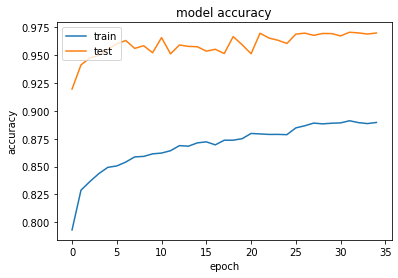

In [122]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()